In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')


In [7]:

dataset = pd.read_csv('HDDAdataexam26.csv', sep=';', decimal=',', on_bad_lines='skip')

print(dataset.head())
print(dataset.describe())


   Phone  SocialNetworks  Happiness  Walk  InstagramRatio
0    360           360.0          6  12.0        1.267717
1    180           130.0          6   3.0        0.542083
2    250           120.0          7   8.0        0.750000
3    120            80.0          8   7.0        1.796407
4    190             1.0          3  10.0        0.846561
             Phone  SocialNetworks   Happiness        Walk  InstagramRatio
count   369.000000      369.000000  369.000000  369.000000      369.000000
mean    125.872629       80.325203    7.460705    6.209675        1.175554
std     132.644476      104.617841    1.621594    3.238059        3.197073
min       1.000000        1.000000    1.000000    1.000000        0.000000
25%      10.000000       30.000000    7.000000    4.000000        0.579295
50%     120.000000       60.000000    8.000000    5.000000        0.961404
75%     180.000000      120.000000    8.000000    8.000000        1.243243
max    1440.000000     1440.000000   10.000000   20.

In [8]:

X = dataset[['Phone', 'SocialNetworks', 'Happiness', 'Walk', 'InstagramRatio']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
pca_result = pca.fit_transform(X_scaled)


In [9]:

eigenvalues = pca.explained_variance_
variance_explained = pca.explained_variance_ratio_ * 100
cumulative_variance = np.cumsum(variance_explained)


In [10]:

eigenvalue_df = pd.DataFrame({
    'Composante': [f'Dim.{i+1}' for i in range(len(eigenvalues))],
    'Valeur propre': eigenvalues,
    'Variance (%)': variance_explained,
    'Variance cumulée (%)': cumulative_variance
})
print(eigenvalue_df.to_string(index=False))


Composante  Valeur propre  Variance (%)  Variance cumulée (%)
     Dim.1       1.752186     34.948755             34.948755
     Dim.2       1.148618     22.910107             57.858862
     Dim.3       0.943041     18.809711             76.668573
     Dim.4       0.895527     17.861992             94.530565
     Dim.5       0.274215      5.469435            100.000000


In [11]:

n_components_kaiser = np.sum(eigenvalues > 1)
print(f"\nCritère de Kaiser: {n_components_kaiser} composante(s) avec valeur propre > 1")
print(f"Variance expliquée: {cumulative_variance[n_components_kaiser-1]:.2f}%")

loadings = pca.components_.T * np.sqrt(eigenvalues)
loadings_df = pd.DataFrame(
    loadings,
    columns=[f'Dim.{i+1}' for i in range(pca.n_components_)],
    index=X.columns
)

print(loadings_df)

# Contributions des variables
contrib_var = (loadings**2 / eigenvalues) * 100
contrib_var_df = pd.DataFrame(
    contrib_var,
    columns=[f'Dim.{i+1}' for i in range(pca.n_components_)],
    index=X.columns
)

print(contrib_var_df)

# Qualité de représentation (cos2)
cos2_var = loadings**2
cos2_var_df = pd.DataFrame(
    cos2_var,
    columns=[f'Dim.{i+1}' for i in range(pca.n_components_)],
    index=X.columns
)

print(cos2_var_df)



Critère de Kaiser: 2 composante(s) avec valeur propre > 1
Variance expliquée: 57.86%
                   Dim.1     Dim.2     Dim.3     Dim.4     Dim.5
Phone           0.922603 -0.111916  0.036800 -0.005526  0.370959
SocialNetworks  0.909735 -0.152569  0.033971  0.130787 -0.365463
Happiness      -0.200110 -0.623658 -0.368208  0.660285  0.046602
Walk           -0.178062 -0.503354  0.845757  0.047574  0.008873
InstagramRatio  0.040272  0.685931  0.299419  0.663439  0.028119
                    Dim.1      Dim.2      Dim.3      Dim.4      Dim.5
Phone           48.579145   1.090463   0.143601   0.003410  50.183381
SocialNetworks  47.233412   2.026555   0.122375   1.910068  48.707590
Happiness        2.285377  33.862315  14.376588  48.683736   0.791985
Walk             1.809507  22.058279  75.850773   0.252733   0.028708
InstagramRatio   0.092560  40.962389   9.506662  49.150053   0.288337
                   Dim.1     Dim.2     Dim.3     Dim.4     Dim.5
Phone           0.851197  0.012525  0.0

- 2 composante(s) principale(s) retenue(s) (critère de Kaiser)
- Variance totale expliquée: 57.86%
- Dim.1 explique 34.95% de la variance
- Dim.2 explique 22.91% de la variance



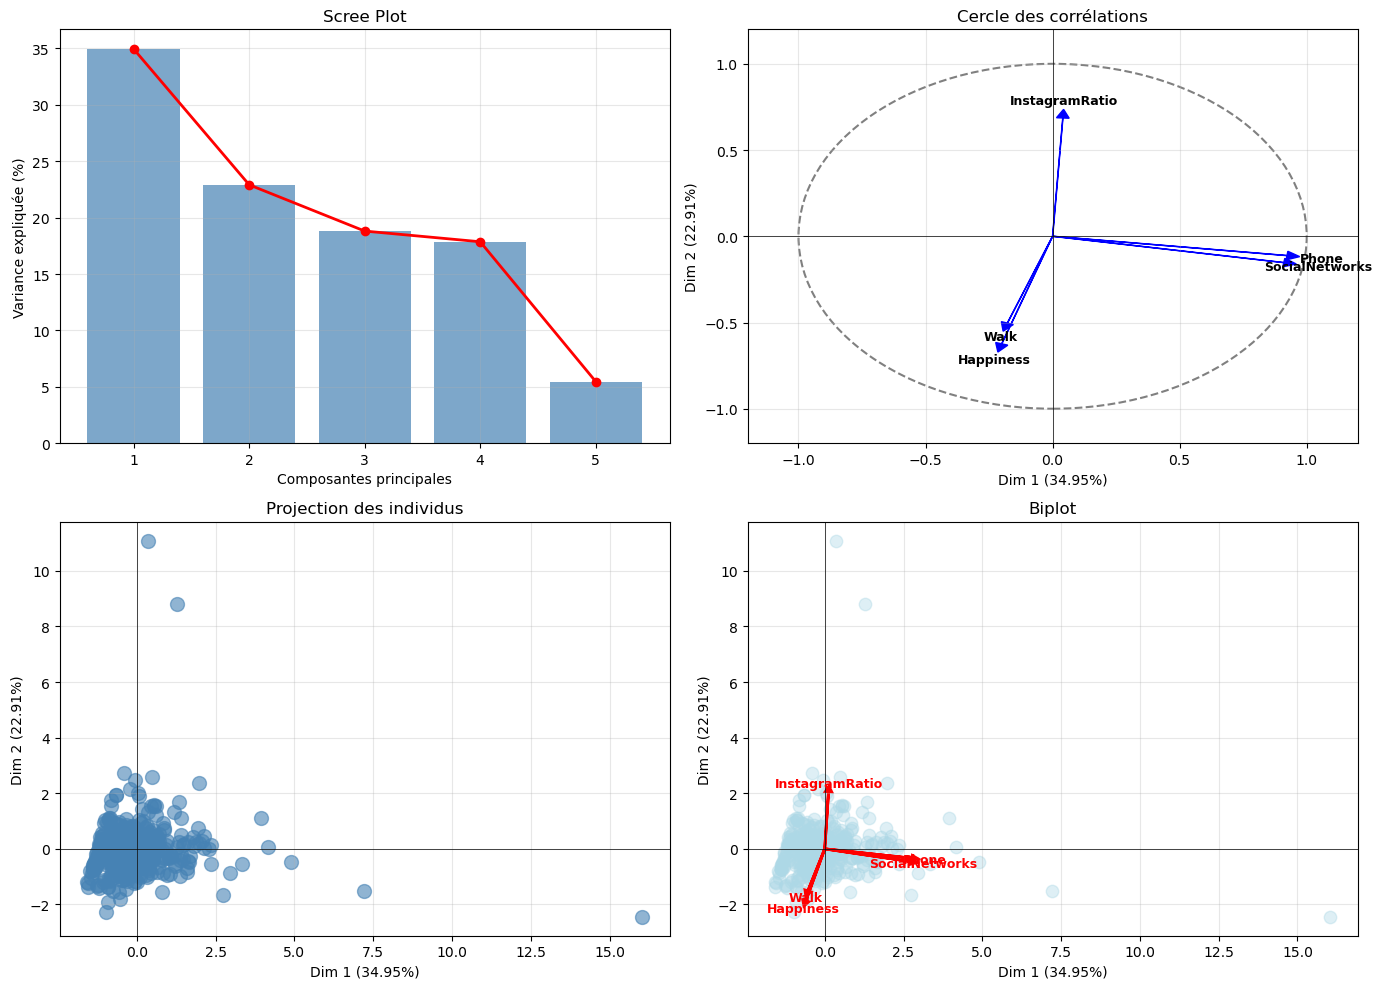

In [12]:

# Visualisations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Scree plot
axes[0, 0].bar(range(1, len(eigenvalues) + 1), variance_explained, alpha=0.7, color='steelblue')
axes[0, 0].plot(range(1, len(eigenvalues) + 1), variance_explained, 'ro-', linewidth=2)
axes[0, 0].set_xlabel('Composantes principales')
axes[0, 0].set_ylabel('Variance expliquée (%)')
axes[0, 0].set_title('Scree Plot')
axes[0, 0].grid(alpha=0.3)

# Cercle des corrélations
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', linewidth=1.5)
axes[0, 1].add_patch(circle)
for i, var in enumerate(X.columns):
    axes[0, 1].arrow(0, 0, loadings[i, 0], loadings[i, 1], 
                     head_width=0.05, head_length=0.05, fc='blue', ec='blue')
    axes[0, 1].text(loadings[i, 0] * 1.15, loadings[i, 1] * 1.15, var, 
                    fontsize=9, ha='center', va='center', fontweight='bold')
axes[0, 1].set_xlabel(f'Dim 1 ({variance_explained[0]:.2f}%)')
axes[0, 1].set_ylabel(f'Dim 2 ({variance_explained[1]:.2f}%)')
axes[0, 1].set_title('Cercle des corrélations')
axes[0, 1].axhline(y=0, color='k', linewidth=0.5)
axes[0, 1].axvline(x=0, color='k', linewidth=0.5)
axes[0, 1].set_xlim(-1.2, 1.2)
axes[0, 1].set_ylim(-1.2, 1.2)
axes[0, 1].grid(alpha=0.3)

# Projection des individus
axes[1, 0].scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6, s=100, c='steelblue')
axes[1, 0].set_xlabel(f'Dim 1 ({variance_explained[0]:.2f}%)')
axes[1, 0].set_ylabel(f'Dim 2 ({variance_explained[1]:.2f}%)')
axes[1, 0].set_title('Projection des individus')
axes[1, 0].axhline(y=0, color='k', linewidth=0.5)
axes[1, 0].axvline(x=0, color='k', linewidth=0.5)
axes[1, 0].grid(alpha=0.3)

# Biplot
scaling_factor = 3
axes[1, 1].scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.4, s=80, c='lightblue')
for i, var in enumerate(X.columns):
    axes[1, 1].arrow(0, 0, loadings[i, 0] * scaling_factor, loadings[i, 1] * scaling_factor,
                     head_width=0.2, head_length=0.2, fc='red', ec='red', linewidth=2)
    axes[1, 1].text(loadings[i, 0] * scaling_factor * 1.15, loadings[i, 1] * scaling_factor * 1.15, 
                    var, fontsize=9, ha='center', va='center', fontweight='bold', color='red')
axes[1, 1].set_xlabel(f'Dim 1 ({variance_explained[0]:.2f}%)')
axes[1, 1].set_ylabel(f'Dim 2 ({variance_explained[1]:.2f}%)')
axes[1, 1].set_title('Biplot')
axes[1, 1].axhline(y=0, color='k', linewidth=0.5)
axes[1, 1].axvline(x=0, color='k', linewidth=0.5)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('pca_analysis.png', dpi=300, bbox_inches='tight')

print(f"- {n_components_kaiser} composante(s) principale(s) retenue(s) (critère de Kaiser)")
print(f"- Variance totale expliquée: {cumulative_variance[n_components_kaiser-1]:.2f}%")
print(f"- Dim.1 explique {variance_explained[0]:.2f}% de la variance")
print(f"- Dim.2 explique {variance_explained[1]:.2f}% de la variance")
print()


In [13]:

dataset['LowInstagram'] = (dataset['InstagramRatio'] < 0.5).astype(int)
dataset['HighInstagram'] = (dataset['InstagramRatio'] > 2).astype(int)

print("Vérification:")
print(dataset[['InstagramRatio', 'LowInstagram', 'HighInstagram']].head(10))
print()


Vérification:
   InstagramRatio  LowInstagram  HighInstagram
0        1.267717             0              0
1        0.542083             0              0
2        0.750000             0              0
3        1.796407             0              0
4        0.846561             0              0
5        1.037182             0              0
6        0.000000             1              0
7        0.925781             0              0
8        0.644135             0              0
9        1.060498             0              0



In [14]:

formula = 'Phone ~ SocialNetworks + Happiness + Walk + LowInstagram + HighInstagram'
model2 = ols(formula, data=dataset).fit()

print("Modèle: Phone ~ SocialNetworks + Happiness + Walk + LowInstagram + HighInstagram")
print()
print(model2.summary())
print()


Modèle: Phone ~ SocialNetworks + Happiness + Walk + LowInstagram + HighInstagram

                            OLS Regression Results                            
Dep. Variable:                  Phone   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     83.61
Date:                Tue, 20 Jan 2026   Prob (F-statistic):           2.93e-58
Time:                        17:58:28   Log-Likelihood:                -2185.3
No. Observations:                 369   AIC:                             4383.
Df Residuals:                     363   BIC:                             4406.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

In [15]:


f_statistic = model2.fvalue
f_pvalue = model2.f_pvalue

print(f"Test F de nullité de tous les coefficients (sauf la constante):")
print(f"F-statistic = {f_statistic:.4f}")
print(f"P-value = {f_pvalue:.6f}")
print()

if f_pvalue < 0.05:
    print("  Au moins un prédicteur a un effet significatif sur Phone.")
else:
    print("  Un modèle linéaire n'est pas approprié pour prédire Phone.")
print()


Test F de nullité de tous les coefficients (sauf la constante):
F-statistic = 83.6109
P-value = 0.000000

  Au moins un prédicteur a un effet significatif sur Phone.



In [16]:

sn_coef = model2.params['SocialNetworks']
sn_pvalue = model2.pvalues['SocialNetworks']
sn_tvalue = model2.tvalues['SocialNetworks']

print(f"Variable: SocialNetworks")
print(f"Coefficient: {sn_coef:.4f}")
print(f"T-statistic: {sn_tvalue:.4f}")
print(f"P-value: {sn_pvalue:.6f}")
print()

if sn_pvalue < 0.05:
    print("SocialNetworks influence SIGNIFICATIVEMENT Phone (p-value < 0.05)")
    if sn_coef > 0:
        print(f"  Chaque minute supplémentaire sur les réseaux sociaux augmente Phone de {sn_coef:.4f} minutes.")
    else:
        print(f"  Chaque minute supplémentaire sur les réseaux sociaux diminue Phone de {abs(sn_coef):.4f} minutes.")
else:
    print(" SocialNetworks n'influence PAS significativement Phone (p-value > 0.05)")
print()


Variable: SocialNetworks
Coefficient: 0.9108
T-statistic: 20.0269
P-value: 0.000000

SocialNetworks influence SIGNIFICATIVEMENT Phone (p-value < 0.05)
  Chaque minute supplémentaire sur les réseaux sociaux augmente Phone de 0.9108 minutes.



In [17]:

hap_coef = model2.params['Happiness']
hap_pvalue = model2.pvalues['Happiness']
hap_tvalue = model2.tvalues['Happiness']

print(f"Variable: Happiness")
print(f"Coefficient: {hap_coef:.4f}")
print(f"T-statistic: {hap_tvalue:.4f}")
print(f"P-value: {hap_pvalue:.6f}")
print()

if hap_pvalue < 0.05 and hap_coef < 0:
    print(f"  Chaque point de bonheur supplémentaire réduit Phone de {abs(hap_coef):.4f} minutes.")
    print(" Oui, le bonheur aide à réduire le temps sur le téléphone.")
elif hap_pvalue < 0.05 and hap_coef > 0:
    print(f"  Chaque point de bonheur supplémentaire augmente Phone de {hap_coef:.4f} minutes.")
    print(" Non, le bonheur n'aide PAS à réduire le temps sur le téléphone.")
else:
    print("Happiness n'a PAS d'impact significatif sur Phone (p-value > 0.05)")
    print(" On ne peut pas conclure que le bonheur réduit le temps sur le téléphone.")
print()


Variable: Happiness
Coefficient: -7.3951
T-statistic: -2.4879
P-value: 0.013297

  Chaque point de bonheur supplémentaire réduit Phone de 7.3951 minutes.
 Oui, le bonheur aide à réduire le temps sur le téléphone.



In [18]:

# Étudiant A: InstagramRatio = 2.1 > 2 → HighInstagram = 1, LowInstagram = 0
student_A = pd.DataFrame({
    'SocialNetworks': [120],
    'Happiness': [4],
    'Walk': [15],
    'LowInstagram': [0],
    'HighInstagram': [1]
})

# Étudiant B: InstagramRatio = 0.4 < 0.5 → LowInstagram = 1, HighInstagram = 0
student_B = pd.DataFrame({
    'SocialNetworks': [120],
    'Happiness': [4],
    'Walk': [15],
    'LowInstagram': [1],
    'HighInstagram': [0]
})

Phone_A = model2.predict(student_A)[0]
Phone_B = model2.predict(student_B)[0]

print(f"  Phone(A) = {Phone_A:.4f} minutes")
print(f"  Phone(B) = {Phone_B:.4f} minutes")
print()
print(f"Différence: Phone(A) - Phone(B) = {Phone_A - Phone_B:.4f} minutes")


  Phone(A) = 142.4649 minutes
  Phone(B) = 195.1332 minutes

Différence: Phone(A) - Phone(B) = -52.6683 minutes


In [19]:

predictors = ['SocialNetworks', 'Happiness', 'Walk', 'LowInstagram', 'HighInstagram']
step_num = 0

print(f"Prédicteurs: {', '.join(predictors)}")

formula_current = 'Phone ~ ' + ' + '.join(predictors)
current_model = ols(formula_current, data=dataset).fit()

pvalues = current_model.pvalues[1:]  # Sans l'intercept

print("P-values:")
for var, pval in pvalues.items():
    signif = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else "NS"
    print(f"  {var:20s}: {pval:.6f} {signif}")

max_pvalue_var = pvalues.idxmax()
max_pvalue = pvalues.max()

if max_pvalue > 0.05:
    print(f"\n Variable à éliminer: {max_pvalue_var} (p-value = {max_pvalue:.6f})")
else:
    print("\n Tous les prédicteurs sont significatifs!")
print()

# Boucle d'élimination
while pvalues.max() > 0.05:
    step_num += 1
    
    var_to_remove = pvalues.idxmax()
    predictors.remove(var_to_remove)
    
    formula_current = 'Phone ~ ' + ' + '.join(predictors)
    current_model = ols(formula_current, data=dataset).fit()
    
    pvalues = current_model.pvalues[1:]
    
    print("P-values:")
    for var, pval in pvalues.items():
        signif = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else "NS"
        print(f"  {var:20s}: {pval:.6f} {signif}")
    
    max_pvalue_var = pvalues.idxmax()
    max_pvalue = pvalues.max()
    
    if max_pvalue > 0.05:
        print(f"\n Variable à éliminer: {max_pvalue_var} (p-value = {max_pvalue:.6f})")
    else:
        print("\n Tous les prédicteurs restants sont significatifs au seuil de 5%!")

final_model = current_model
print(f"Formule finale: {formula_current}")
print()
print(final_model.summary())
print()

print("RÉSUMÉ:")
print(f"  R² = {final_model.rsquared:.4f}")
print(f"  R² ajusté = {final_model.rsquared_adj:.4f}")
print(f"  Nombre de prédicteurs: {len(predictors)}")
print()


Prédicteurs: SocialNetworks, Happiness, Walk, LowInstagram, HighInstagram
P-values:
  SocialNetworks      : 0.000000 ***
  Happiness           : 0.013297 *
  Walk                : 0.518838 NS
  LowInstagram        : 0.122151 NS
  HighInstagram       : 0.082057 NS

 Variable à éliminer: Walk (p-value = 0.518838)

P-values:
  SocialNetworks      : 0.000000 ***
  Happiness           : 0.011916 *
  LowInstagram        : 0.103676 NS
  HighInstagram       : 0.084246 NS

 Variable à éliminer: LowInstagram (p-value = 0.103676)
P-values:
  SocialNetworks      : 0.000000 ***
  Happiness           : 0.005940 **
  HighInstagram       : 0.046092 *

 Tous les prédicteurs restants sont significatifs au seuil de 5%!
Formule finale: Phone ~ SocialNetworks + Happiness + HighInstagram

                            OLS Regression Results                            
Dep. Variable:                  Phone   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:         

In [20]:

#Comparaison des modèles
print("\n Modèle2 ")
print(f"  R² ajusté = {model2.rsquared_adj:.4f}")
non_sig_2 = (model2.pvalues[1:] > 0.05).sum()
if non_sig_2 == 0:
    print("Oui")
else:
    print(f"Non ({non_sig_2} non significatif(s))")

print("\nFinal model")
print(f" R² ajusté = {final_model.rsquared_adj:.4f}")

if final_model.rsquared_adj > model2.rsquared_adj:
    best_model = final_model
    print(f"  Raison: R² ajusté plus élevé ({final_model.rsquared_adj:.4f})")
elif final_model.rsquared_adj == model2.rsquared_adj:
    best_model = final_model
    print(f"  Raison: R² ajusté égal mais modèle plus parcimonieux (moins de prédicteurs)")
else:
    if non_sig_2 == 0:
        best_model = model2
        print(f"  Raison: R² ajusté plus élevé ({model2.rsquared_adj:.4f}) ")
    else:
        best_model = final_model
        print(f"Raison: Tous les prédicteurs sont significatifs (principe de parcimonie)")
print(best_model)



 Modèle2 
  R² ajusté = 0.5288
Non (3 non significatif(s))

Final model
 R² ajusté = 0.5275
Raison: Tous les prédicteurs sont significatifs (principe de parcimonie)


In [21]:

student_q9 = pd.DataFrame({
    'SocialNetworks': [30],
    'Happiness': [8],
    'Walk': [2],
    'LowInstagram': [0],
    'HighInstagram': [1]
})

# Vérifier si les variables sont dans le modèle
if best_model == final_model:
    # Créer un DataFrame avec seulement les variables du modèle final
    student_q9_final = student_q9[predictors]
    Phone_q9 = best_model.predict(student_q9_final)[0]
else:
    Phone_q9 = best_model.predict(student_q9)[0]

print(f" Prédiction: Phone = {Phone_q9:.4f} minutes")
print()


 Prédiction: Phone = 38.5746 minutes



In [22]:

student_q10 = pd.DataFrame({
    'SocialNetworks': [30],
    'Happiness': [8],
    'Walk': [2],
    'LowInstagram': [1],
    'HighInstagram': [0]
})

if best_model == final_model:
    student_q10_final = student_q10[predictors]
    Phone_q10 = best_model.predict(student_q10_final)[0]
else:
    Phone_q10 = best_model.predict(student_q10)[0]

print(f"Prédiction: Phone = {Phone_q10:.4f} minutes")
print(f"Différence entre Q9 et Q10: {Phone_q9 - Phone_q10:.4f} minutes")


Prédiction: Phone = 78.0663 minutes
Différence entre Q9 et Q10: -39.4917 minutes
